# Autoencoder as Nonlinear PCA — MNIST (PyTorch)
An autoencoder trained on MNIST with a 2D bottleneck. The 2D latent space is visualized and compared against standard PCA, showing how nonlinear compression produces richer, more separated representations.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm

import torch
import torch.nn as nn
from torch.utils.data import DataLoader

from torchvision import datasets, transforms

from sklearn.decomposition import PCA

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

Using device: cpu


## 1. Load MNIST

In [2]:
transform = transforms.Compose([
    transforms.ToTensor(),                        # [0, 255] -> [0.0, 1.0]
    transforms.Normalize((0.1307,), (0.3081,))    # MNIST mean and std
])

train_set = datasets.MNIST(root='./data', train=True,  download=True, transform=transform)
test_set  = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

train_loader = DataLoader(train_set, batch_size=256, shuffle=True,  num_workers=2, pin_memory=True)
test_loader  = DataLoader(test_set,  batch_size=256, shuffle=False, num_workers=2, pin_memory=True)

print(f'Train: {len(train_set):,} | Test: {len(test_set):,}')
print(f'Image shape: {train_set[0][0].shape}')    # (1, 28, 28)

100%|██████████| 9.91M/9.91M [00:00<00:00, 24.2MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 677kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 5.79MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 2.26MB/s]

Train: 60,000 | Test: 10,000
Image shape: torch.Size([1, 28, 28])


## 2. Visualize Samples

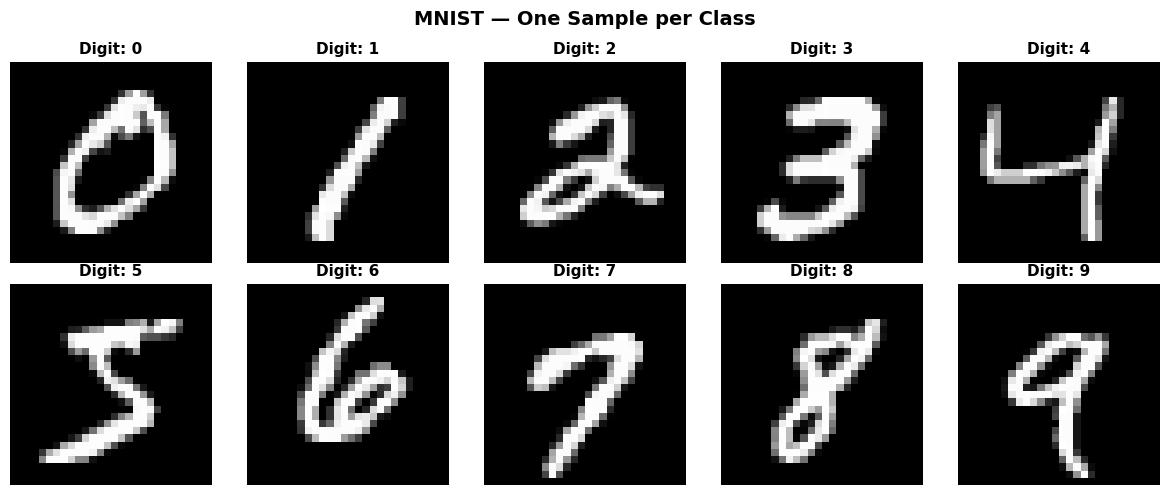

In [3]:
raw_set = datasets.MNIST(root='./data', train=True, download=False,
                          transform=transforms.ToTensor())

fig, axes = plt.subplots(2, 5, figsize=(12, 5))
for i, ax in enumerate(axes.flat):
    idx = next(j for j, (_, y) in enumerate(raw_set) if y == i)
    img, label = raw_set[idx]
    ax.imshow(img.squeeze(), cmap='gray')
    ax.set_title(f'Digit: {label}', fontsize=11, fontweight='bold')
    ax.axis('off')

plt.suptitle('MNIST — One Sample per Class', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

## 3. Autoencoder Architecture

The autoencoder has two components:
- **Encoder**: compresses 784-dimensional input down to a 2D latent vector
- **Decoder**: reconstructs the 784-dimensional image from the 2D code

The 2D bottleneck forces the network to learn the most informative 2D representation of the data — nonlinear PCA.

```
Encoder: 784 -> 256 -> 128 -> 2   (bottleneck)
Decoder:   2 -> 128 -> 256 -> 784
```

In [4]:
class Encoder(nn.Module):
    def __init__(self, latent_dim=2):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(784, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, latent_dim)    # bottleneck — no activation
        )

    def forward(self, x):
        return self.net(x)


class Decoder(nn.Module):
    def __init__(self, latent_dim=2):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(latent_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 256),
            nn.ReLU(),
            nn.Linear(256, 784),
            nn.Sigmoid()                  # output in [0, 1] to match pixel range
        )

    def forward(self, z):
        return self.net(z)


class Autoencoder(nn.Module):
    def __init__(self, latent_dim=2):
        super().__init__()
        self.encoder = Encoder(latent_dim)
        self.decoder = Decoder(latent_dim)

    def forward(self, x):
        z    = self.encoder(x)
        x_hat = self.decoder(z)
        return x_hat, z


LATENT_DIM = 2
model = Autoencoder(latent_dim=LATENT_DIM).to(device)

total_params = sum(p.numel() for p in model.parameters())
print(f'Total parameters: {total_params:,}')
print(model)

Total parameters: 469,010
Autoencoder(
  (encoder): Encoder(
    (net): Sequential(
      (0): Linear(in_features=784, out_features=256, bias=True)
      (1): ReLU()
      (2): Linear(in_features=256, out_features=128, bias=True)
      (3): ReLU()
      (4): Linear(in_features=128, out_features=2, bias=True)
    )
  )
  (decoder): Decoder(
    (net): Sequential(
      (0): Linear(in_features=2, out_features=128, bias=True)
      (1): ReLU()
      (2): Linear(in_features=128, out_features=256, bias=True)
      (3): ReLU()
      (4): Linear(in_features=256, out_features=784, bias=True)
      (5): Sigmoid()
    )
  )
)


## 4. Training

In [5]:
EPOCHS   = 30
LR       = 1e-3
PATIENCE = 5

# MSE loss — measures pixel-wise reconstruction error
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LR)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=3, factor=0.5, verbose=True)

train_losses, best_loss = [], float('inf')
best_state, patience_counter = None, 0

for epoch in range(1, EPOCHS + 1):
    model.train()
    running_loss = 0.0

    for X, _ in train_loader:                       # labels not used — unsupervised
        X = X.view(X.size(0), -1).to(device)        # flatten: (B, 1, 28, 28) -> (B, 784)
        optimizer.zero_grad()
        X_hat, _ = model(X)
        loss = criterion(X_hat, X)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * len(X)

    train_loss = running_loss / len(train_loader.dataset)
    train_losses.append(train_loss)
    scheduler.step(train_loss)

    if train_loss < best_loss:
        best_loss = train_loss
        best_state = {k: v.cpu().clone() for k, v in model.state_dict().items()}
        patience_counter = 0
    else:
        patience_counter += 1

    print(f'Epoch {epoch:3d}/{EPOCHS} | Loss: {train_loss:.6f}')

    if patience_counter >= PATIENCE:
        print(f'\nEarly stopping at epoch {epoch}')
        break

model.load_state_dict(best_state)
print(f'\nBest loss: {best_loss:.6f}')

c:\Users\felip\anaconda3\Lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch   1/30 | Loss: 0.770572
Epoch   2/30 | Loss: 0.703008
Epoch   3/30 | Loss: 0.688543
Epoch   4/30 | Loss: 0.679554
Epoch   5/30 | Loss: 0.673514
Epoch   6/30 | Loss: 0.669702
Epoch   7/30 | Loss: 0.666566
Epoch   8/30 | Loss: 0.664477
Epoch   9/30 | Loss: 0.662701
Epoch  10/30 | Loss: 0.661058
Epoch  11/30 | Loss: 0.659856
Epoch  12/30 | Loss: 0.658801
Epoch  13/30 | Loss: 0.657433
Epoch  14/30 | Loss: 0.656213
Epoch  15/30 | Loss: 0.655445
Epoch  16/30 | Loss: 0.654415
Epoch  17/30 | Loss: 0.653507
Epoch  18/30 | Loss: 0.652608
Epoch  19/30 | Loss: 0.651819
Epoch  20/30 | Loss: 0.651096
Epoch  21/30 | Loss: 0.650383
Epoch  22/30 | Loss: 0.649977
Epoch  23/30 | Loss: 0.649461
Epoch  24/30 | Loss: 0.648692
Epoch  25/30 | Loss: 0.648030
Epoch  26/30 | Loss: 0.647196
Epoch  27/30 | Loss: 0.646741
Epoch  28/30 | Loss: 0.646304
Epoch  29/30 | Loss: 0.646025
Epoch  30/30 | Loss: 0.645653

Best loss: 0.645653


## 5. Loss Curve

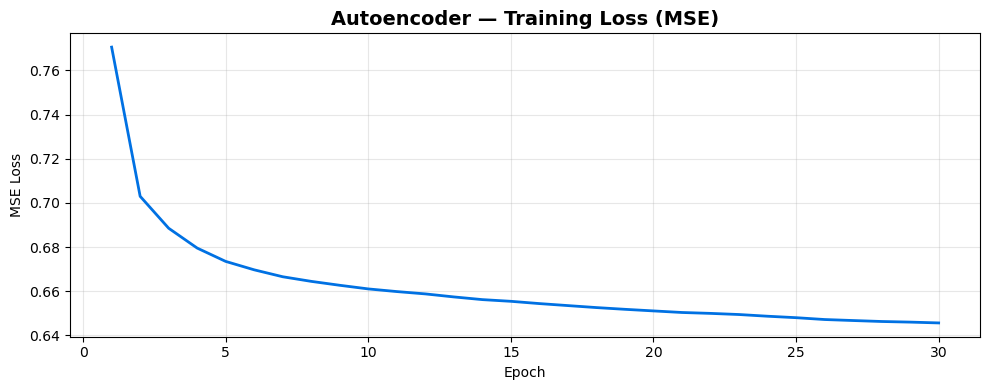

In [6]:
plt.figure(figsize=(10, 4))
plt.plot(range(1, len(train_losses) + 1), train_losses, color='#0071e3', linewidth=2)
plt.title('Autoencoder — Training Loss (MSE)', fontsize=14, fontweight='bold')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## 6. Reconstruction Quality

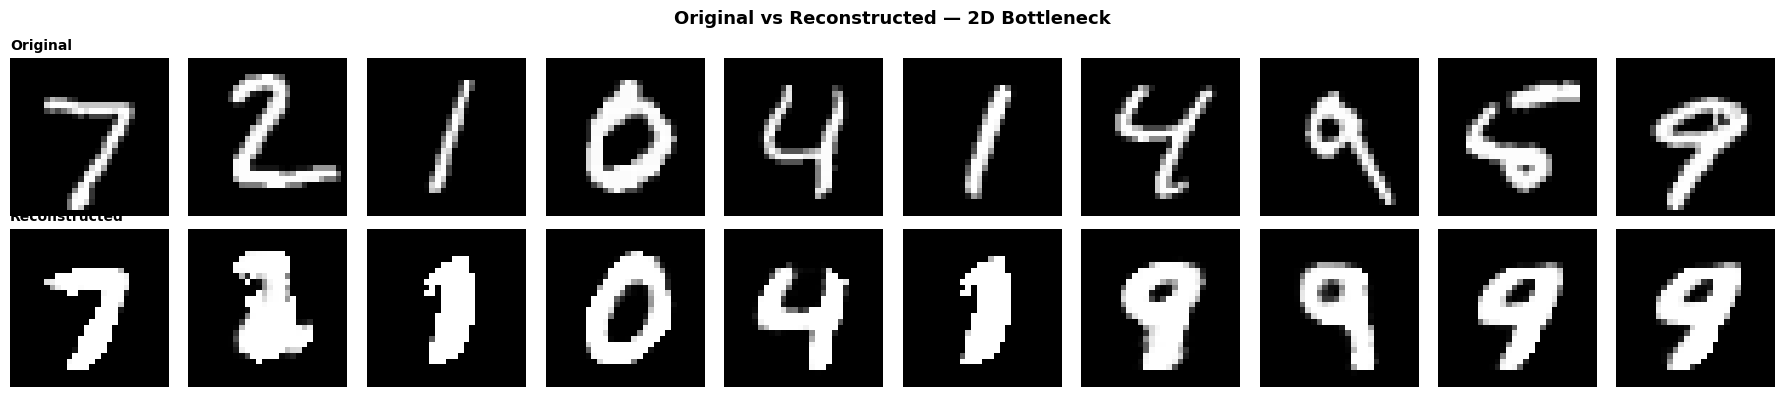

In [7]:
model.eval()
X_sample, y_sample = next(iter(test_loader))
X_flat = X_sample.view(X_sample.size(0), -1).to(device)

with torch.no_grad():
    X_hat, _ = model(X_flat)

X_orig = X_flat.cpu().numpy()
X_recon = X_hat.cpu().numpy()

n = 10
fig, axes = plt.subplots(2, n, figsize=(18, 4))

for i in range(n):
    # Original
    axes[0, i].imshow(X_orig[i].reshape(28, 28), cmap='gray')
    axes[0, i].axis('off')
    if i == 0:
        axes[0, i].set_title('Original', fontsize=10, fontweight='bold', loc='left')

    # Reconstruction
    axes[1, i].imshow(X_recon[i].reshape(28, 28), cmap='gray')
    axes[1, i].axis('off')
    if i == 0:
        axes[1, i].set_title('Reconstructed', fontsize=10, fontweight='bold', loc='left')

plt.suptitle('Original vs Reconstructed — 2D Bottleneck', fontsize=13, fontweight='bold')
plt.tight_layout()
plt.show()

## 7. 2D Latent Space — Autoencoder

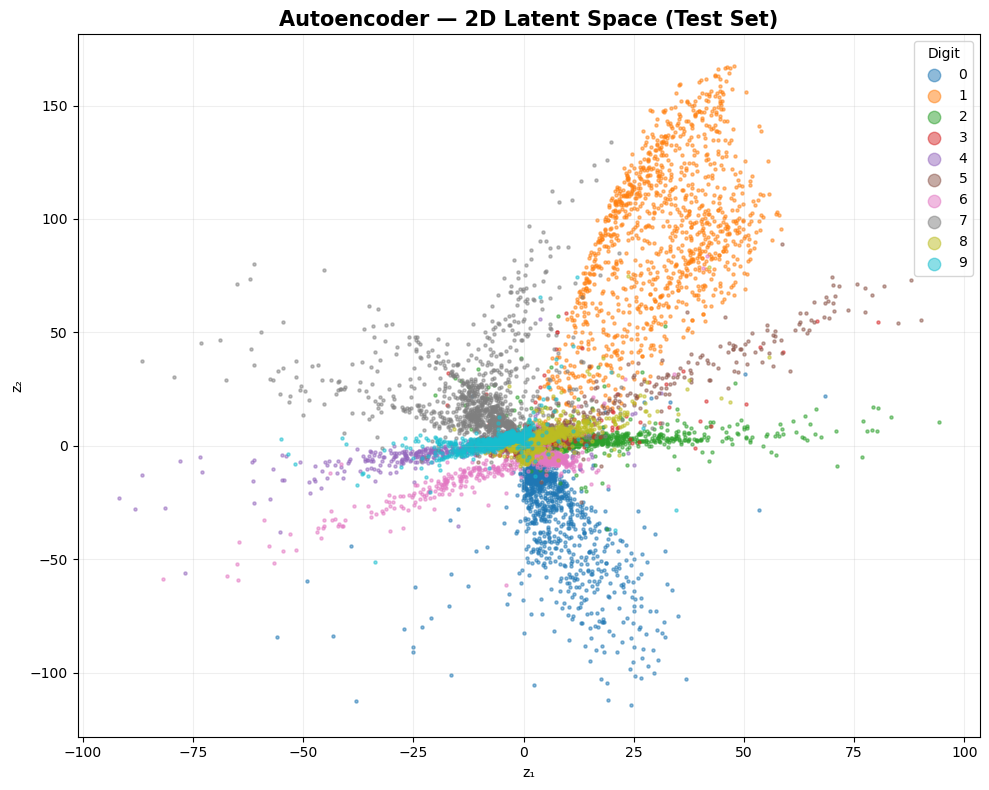

In [8]:
model.eval()
all_z, all_labels = [], []

with torch.no_grad():
    for X, y in test_loader:
        X_flat = X.view(X.size(0), -1).to(device)
        _, z = model(X_flat)
        all_z.append(z.cpu().numpy())
        all_labels.append(y.numpy())

all_z      = np.concatenate(all_z,      axis=0)   # (10000, 2)
all_labels = np.concatenate(all_labels, axis=0)   # (10000,)

colors = cm.tab10(np.linspace(0, 1, 10))

plt.figure(figsize=(10, 8))
for digit in range(10):
    mask = all_labels == digit
    plt.scatter(all_z[mask, 0], all_z[mask, 1],
                c=[colors[digit]], label=str(digit),
                s=5, alpha=0.5)

plt.title('Autoencoder — 2D Latent Space (Test Set)', fontsize=15, fontweight='bold')
plt.xlabel('z₁')
plt.ylabel('z₂')
plt.legend(title='Digit', markerscale=4, fontsize=10, loc='best')
plt.grid(True, alpha=0.2)
plt.tight_layout()
plt.show()

## 8. PCA Baseline — 2D Projection

Standard linear PCA for direct comparison with the autoencoder's learned 2D space.

PCA explained variance: 17.59%


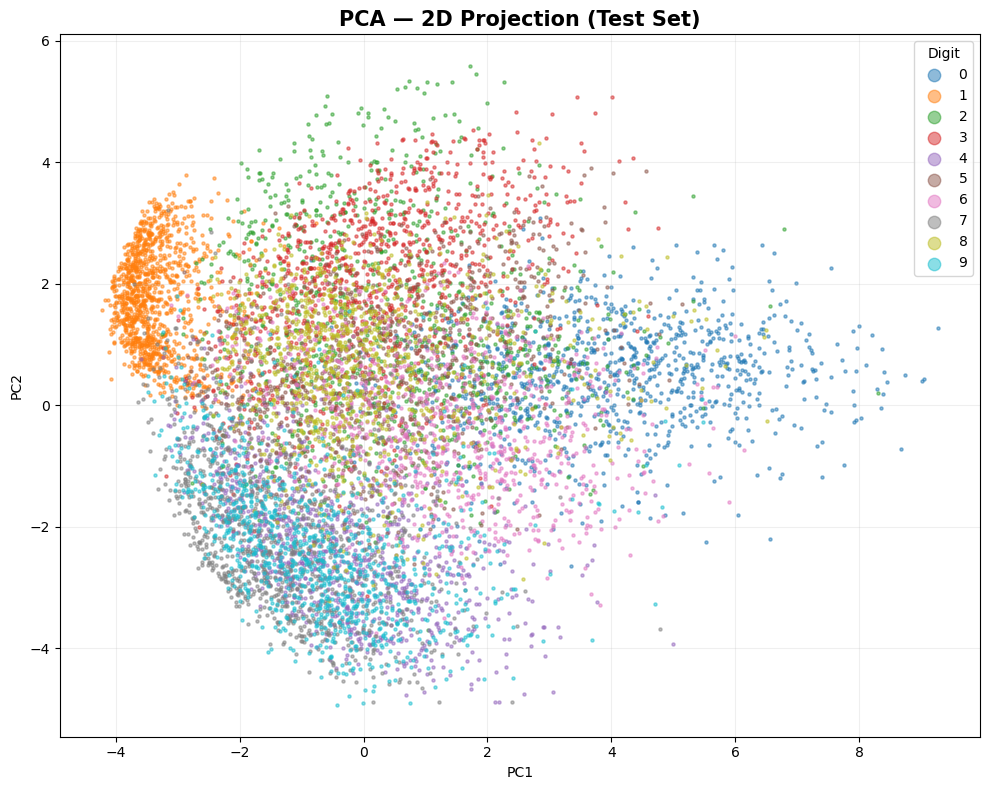

In [9]:
# Get full test set as flat numpy array
X_test_flat  = test_set.data.numpy().reshape(-1, 784).astype(np.float32) / 255.0
y_test_labels = test_set.targets.numpy()

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_test_flat)

print(f'PCA explained variance: {pca.explained_variance_ratio_.sum()*100:.2f}%')

plt.figure(figsize=(10, 8))
for digit in range(10):
    mask = y_test_labels == digit
    plt.scatter(X_pca[mask, 0], X_pca[mask, 1],
                c=[colors[digit]], label=str(digit),
                s=5, alpha=0.5)

plt.title('PCA — 2D Projection (Test Set)', fontsize=15, fontweight='bold')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.legend(title='Digit', markerscale=4, fontsize=10, loc='best')
plt.grid(True, alpha=0.2)
plt.tight_layout()
plt.show()

## 9. Side-by-Side Comparison — Autoencoder vs PCA

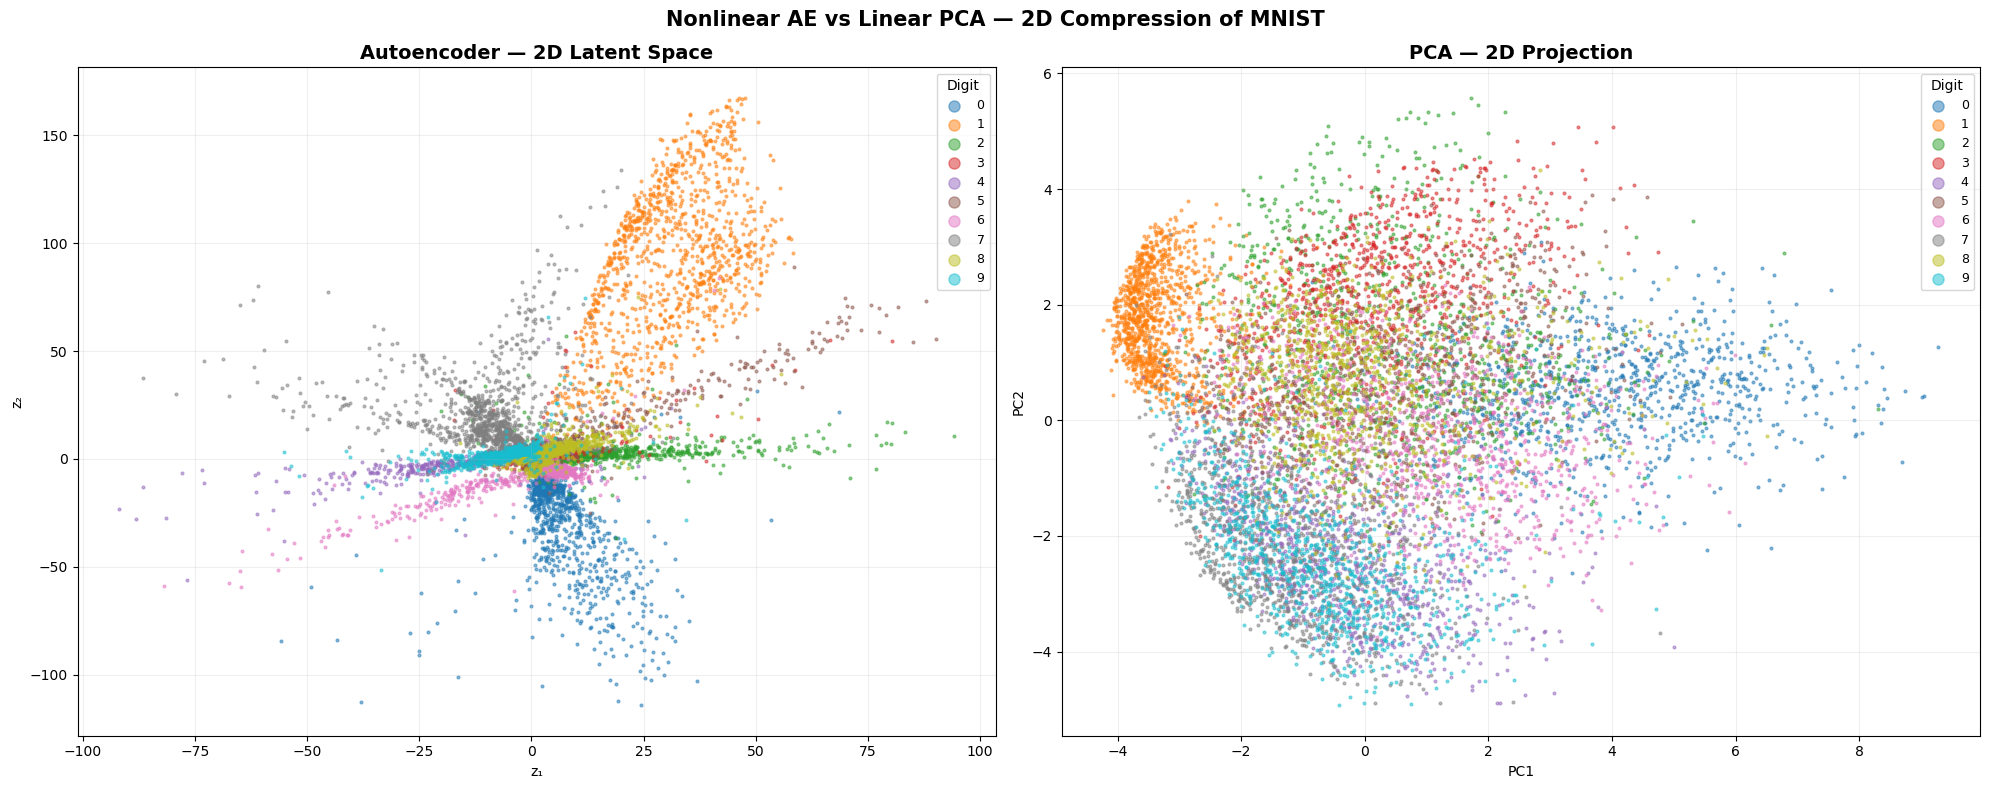

In [10]:
fig, axes = plt.subplots(1, 2, figsize=(20, 8))

for digit in range(10):
    mask = all_labels == digit
    axes[0].scatter(all_z[mask, 0], all_z[mask, 1],
                    c=[colors[digit]], label=str(digit), s=4, alpha=0.5)

axes[0].set_title('Autoencoder — 2D Latent Space', fontsize=14, fontweight='bold')
axes[0].set_xlabel('z₁'); axes[0].set_ylabel('z₂')
axes[0].legend(title='Digit', markerscale=4, fontsize=9)
axes[0].grid(True, alpha=0.2)

for digit in range(10):
    mask = y_test_labels == digit
    axes[1].scatter(X_pca[mask, 0], X_pca[mask, 1],
                    c=[colors[digit]], label=str(digit), s=4, alpha=0.5)

axes[1].set_title('PCA — 2D Projection', fontsize=14, fontweight='bold')
axes[1].set_xlabel('PC1'); axes[1].set_ylabel('PC2')
axes[1].legend(title='Digit', markerscale=4, fontsize=9)
axes[1].grid(True, alpha=0.2)

plt.suptitle('Nonlinear AE vs Linear PCA — 2D Compression of MNIST',
             fontsize=15, fontweight='bold')
plt.tight_layout()
plt.show()